# Homework 2
#### Name: Syed Zain Raza
#### CWID: 20011917

In [12]:
# optional: allow Jupyter to "hot reload" the Python modules I wrote, to avoid restarting the kernel after every change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem 1: Teddy Stereo

### Part 1: Loading the Images

In [2]:
from util import ops

In [3]:
left_img = ops.load_image(
    "./teddy/teddyL.pgm",
    return_grayscale=True,
    return_array=True,
)

Dimensions of ./teddy/teddyL.pgm: 375 x 450


In [4]:
right_img = ops.load_image(
    "./teddy/teddyR.pgm",
    return_grayscale=True,
    return_array=True,
)

Dimensions of ./teddy/teddyR.pgm: 375 x 450


In [55]:
teddy_disparity_map = ops.load_image(
    "./teddy/disp2.pgm",
    return_grayscale=True,
    return_array=True,
)

Dimensions of ./teddy/disp2.pgm: 375 x 450


### Part 2: Preprocessing

#### Using the Rank Transform

In [5]:
import numpy as np

class RankTransform2D:
    """Performs rank filtering on an image."""
    @staticmethod
    def transform(
        image: np.ndarray,
        filter_side_length: int,
        do_logging: bool = False,
    ) -> np.ndarray:
        """
        Produce a new image where each cell value
        represents the "rank" of the corresponding pixel in the input
        (i.e., the index of said pixel in a sorted list of itself &
        the neighboring pixel values).

        Parameters:
            image(np.ndarray): in case its RGB, the transform will be
                                per channel. Please pass the image in
                                channels-last format.
            filter_side_length(int): this is k. The size of each local neighborhood
                              will be kxk. Please pass an odd value > 0.
            do_logging(bool): enables print statements to display intermediate
                              values during execution

        Returns: np.ndarray: the transformed image
        """
        ### HELPER(S)
        def compute_rank(
            channel: np.ndarray,
            kernel: np.ndarray,
            row_index: int,
            col_index: int,
        ) -> float:
            """
            Computes the rank of 1 local window of the image.

            Parameters:
                channel(array-like): one of the channels of the input image
                kernel(array-like): tells us the size of the window
                row_index, col_index: int: the coordinates of the upper left corner
                                            of the block of pixels being ranked

            Returns: int: the rank of the center pixel of the window
            """
            # A: define useful vars
            kernel_h, kernel_w = kernel.shape
            # B: get the block of pixels needed for the convolution
            block_of_pixels = channel[
                row_index : (kernel_h + row_index),
                col_index : (kernel_w + col_index)
            ]
            # C: count the of # higher than the center
            center_val = block_of_pixels[kernel_h // 2, kernel_w // 2]
            if do_logging:
                print(f"I think that {center_val} is at the center of {block_of_pixels}")
            transformed_block = np.where(block_of_pixels < center_val, 1, 0)
            if do_logging:
                print(f"Transformed block <{block_of_pixels}> into: <{transformed_block}>")
            return np.sum(transformed_block)

        ### DRIVER
        # data validation
        assert isinstance(image, np.ndarray)
        assert image.shape > (0, 0)
        assert isinstance(filter_side_length, int)
        assert filter_side_length > 0 and filter_side_length % 2 == 1

        # make a copy of the img, padded - will be an intermediate repr
        kernel = np.ones((filter_side_length, filter_side_length))
        num_channels = -1
        if len(image.shape) == 2:  # grayscale
            num_channels = 1
            padded_image, _, _ = ops.pad(
                image, kernel, stride=1, padding_type="zero"
            )
        elif len(image.shape) == 3:  # RGB
            num_channels = image.shape[2]
            channels = [
                ops.pad(image[:, :, channel_index], kernel, stride=1, padding_type="zero")[0]
                for channel_index in range(num_channels)
            ]
            padded_image = np.dstack(channels)

        # fill in the output
        stride = 1
        output_image = list()
        for image_channel_index in np.arange(num_channels):
            transformed_channel = list()
            channel = (
                padded_image[:, :, image_channel_index]
                if num_channels > 1
                else padded_image
            )
            kernel_h, _ = kernel.shape
            # iterate over the rows and columns
            starting_row_ndx = 0
            while starting_row_ndx <= len(channel) - kernel_h:
                # convolve the next row of this channel
                next_channel_row = ops.slide_kernel_over_image(
                    channel,
                    kernel,
                    starting_row_ndx,
                    stride,
                    apply=compute_rank,
                )
                # now, add the convolved row to the list
                transformed_channel.append(next_channel_row)
                # move to the next starting row for the filtering
                starting_row_ndx += stride
            output_image.append(transformed_channel)
        # stack the channels, and return
        return np.dstack(output_image).squeeze()

#### Test: Rank Transform the Left View

In [6]:
transformed_left = RankTransform2D.transform(
    left_img, filter_side_length=5, do_logging=False,
)

Sanity check to make sure the rank transform produced a new image of the same dimensions as the input:

In [7]:
transformed_left.shape == left_img.shape

True

### Part 2: Computing a Disparity Map

In [59]:
from __future__ import annotations
from dataclasses import dataclass
import functools
from typing import Literal, Union

import matplotlib.pyplot as plt
import numpy as np

from util import ops
from util.ops import SimilarityMeasure


@dataclass
class SimpleStereoDisparityMap:
    """
    Computes a disparity map between two images based on the
    assumptions that they are:
        1) of the same shape,

        2) grayscale,

        3) and already rectified.
    """
    left_image: np.ndarray
    right_image: np.ndarray
    stride: int = 1
    padding_type: Union[Literal["zero"], Literal["repeat"]] = "zero"

    def compute(
        self: SimpleStereoDisparityMap,
        similarity_measure: SimilarityMeasure,
        rank_transform_filter_side_length: int,
        window_size: int,
        do_logging: bool = False,
        max_disparity_level: int = 63
    ) -> np.ndarray:
        """
        Compute pixel-wise disparity by searching in the second image
        the most similar patch along the same row in the first image.
        """
        ### HELPER(S)
        def _compute_patch_sum(
                starting_col: np.ndarray,
                starting_row_ndx: int,
                image: np.ndarray,
                kernel_dims: tuple[int, int]  # h, w
            ) -> int:
            """TODO[Zain]: add docstring"""
            kernel_h, kernel_w = kernel_dims
            starting_col_ndx = starting_col[0]
            return np.sum(image[
                starting_row_ndx : int(starting_row_ndx + kernel_h),
                starting_col_ndx : int(starting_col_ndx + kernel_w)
            ])

        def _fetch_image_patches(
            ptr: np.ndarray,  # aka the padded, rank transformed repr of the right image
            left_pixel_block: np.ndarray,
            starting_row_index: int,
            ptr_starting_col_index: int,
        ) -> int:
            """
            TODO[add docstring]

            Args:
                channel: 2D array - one of the channels of the input image
                kernel: 2D array representing the parameters to use
                starting_row_index, ptr_starting_col_index: int: the coordinates of the upper left corner
                                    of the block of pixels being convolved

            Returns: int: TODO
            """
            # form a list of tuple(patch, center_pixel_column)
            kernel_h, kernel_w = left_pixel_block.shape
            right_image_starting_col_indices = np.arange(
                ptr_starting_col_index,
                max(-1, ptr_starting_col_index - max_disparity_level),
                -1 * self.stride
            )
            if do_logging:
                print(
                    f"Starting to fetch patches starting at indices: {right_image_starting_col_indices}."
                )
            patches = np.zeros((
                right_image_starting_col_indices.shape[0],
                kernel_h * kernel_w
            ))
            center_col_indices = np.zeros(right_image_starting_col_indices.shape[0])
            iter_num = 0
            for right_image_starting_col_ndx in right_image_starting_col_indices:
                patch = ptr[
                    starting_row_index : starting_row_index + kernel_h,
                    right_image_starting_col_ndx : right_image_starting_col_ndx + kernel_w,
                ]
                patches[iter_num, :] = patch.reshape(kernel_h*kernel_w)

                right_image_center_col_index = right_image_starting_col_ndx + (kernel_w // 2)
                center_col_indices[iter_num] = right_image_center_col_index

                iter_num += 1
            # for each patch in the row of the right image, compute the SAD with the same block from the first
            compute_sad = functools.partial(
                ops.compute_similarity,
                mode=similarity_measure,
                arr1=left_pixel_block
            )
            # print(f"Patches and center col indices has shape: {patches.shape, center_col_indices.shape}")
            if patches.shape[0] == 0:
                # print(f"Patches: {patches}")
                if do_logging:
                    print("No patches! exiting early with same col, this right image col has no corr with the left image")
                return ptr_starting_col_index
            # TODO[Zain]: optimize in the future
            hypothesis_similarities = np.apply_along_axis(
                lambda arr2: compute_sad(arr2=arr2.reshape((kernel_h, kernel_w))),
                axis=1,
                arr=patches,
            )
            # hypothesis_similarities = list()
            # for patch_index in np.arange(patches.shape[0]):
            #     patch = patches[patch_index, :].reshape((kernel_h, kernel_w))
            #     hypothesis_similarities.append(
            #         compute_sad(arr2=patch)
            #     )
            # hypothesis_similarities = np.array(hypothesis_similarities)
            assert hypothesis_similarities.shape == center_col_indices.shape, (
                f"Expected hypothesis_similarities to have a shape of: {center_col_indices.shape}, ",
                f"but actual shape is: {hypothesis_similarities.shape}",
            )
            # at the end, choose the patch of the right image with the most similarity
            best_center_col_hypothesis = center_col_indices[np.argmin(hypothesis_similarities)]
            return best_center_col_hypothesis

        ### DRIVER
        # data validations
        assert self.left_image.shape == self.right_image.shape, (
            f"Image shape mismatch between left <{self.left_image.shape}>"
            f" and right <{self.right_image.shape}> views."
        )
        assert len(self.left_image.shape) == 2, (
            f"Expected a 2D array representing a grayscale image, "
            f"actual number of channels is: {self.left_image.shape[2]}."
        )
        # rank transform both images
        transformed_left = RankTransform2D.transform(self.left_image, rank_transform_filter_side_length)
        transformed_right = RankTransform2D.transform(self.right_image, rank_transform_filter_side_length)
        # create a square kernel of all 1's using the given window size
        kernel = np.ones((window_size, window_size))
        # pad both images
        padded_transformed_left, _, _ = ops.pad(
            transformed_left,
            kernel,
            stride=self.stride,
            padding_type=self.padding_type
        )
        ptl = padded_transformed_left
        padded_transformed_right, _, _ = ops.pad(
            transformed_right,
            kernel,
            stride=self.stride,
            padding_type=self.padding_type
        )
        ptr = padded_transformed_right
        assert (
            ptl.shape == ptr.shape
        ), f"Shape mismatch after padding: {ptl.shape} != {ptr.shape}"
        # create the output image
        output = np.zeros_like(self.left_image)
        kernel_h, kernel_w = kernel.shape

        compute_patch_sum_helper = functools.partial(
            _compute_patch_sum,
            kernel_dims=kernel.shape,
        )

        # for every row in the first image
        for starting_row_ndx in np.arange(0, ptl.shape[0] - kernel_h, self.stride).astype(int):
            # get all patches in the left image row
            left_image_starting_col_indices = np.arange(0, ptl.shape[1] - kernel_w, self.stride).astype(int).reshape(1, -1)
            left_image_center_col_indices = (left_image_starting_col_indices + (kernel_w // 2)).astype(int).squeeze()

            left_image_patch_sums = np.apply_along_axis(
                func1d=lambda left_image_starting_col: compute_patch_sum_helper(
                    starting_col=left_image_starting_col,
                    image=padded_transformed_left,
                    starting_row_ndx=starting_row_ndx,
                ),
                axis=0,
                arr=left_image_starting_col_indices
            )
            assert left_image_center_col_indices.shape[0] == left_image_patch_sums.shape[0]

            # get all patches in the right image row
            right_image_starting_col_indices = np.arange(0, ptr.shape[1] - kernel_w, self.stride).astype(int).reshape(1, -1)
            right_image_center_col_indices = (right_image_starting_col_indices + (kernel_w // 2)).astype(int).squeeze()

            right_image_patch_sums = np.apply_along_axis(
                func1d=lambda right_image_starting_col: compute_patch_sum_helper(
                    starting_col=right_image_starting_col,
                    image=padded_transformed_right,
                    starting_row_ndx=starting_row_ndx,
                ),
                axis=0,
                arr=right_image_starting_col_indices
            )
            assert right_image_center_col_indices.shape[0] == right_image_patch_sums.shape[0]

            # match correspondences by sorting
            correspondences = np.zeros((right_image_center_col_indices.shape[0], 2))
            correspondences[:, 0] = left_image_center_col_indices[np.argsort(left_image_patch_sums)]
            correspondences[:, 1] = right_image_center_col_indices[np.argsort(right_image_patch_sums)]

            disparity = np.abs(correspondences[:, 0] - correspondences[:, 1])
            disparity = np.where(disparity > 63, 0, disparity)
            if do_logging:
                print(f"left sums: {left_image_patch_sums}")
                print(f"left sums: {right_image_patch_sums}")
                print(f"hypothesized correspondences: {correspondences}")
                # print(f"Upper left corner of patch has coords: ({starting_row_ndx}, {left_image_starting_col_ndx}).")
                # print(f"Window size is {window_size}, so center is at col index: {left_block_center_pixel_index}")
            assert np.min(disparity) >= 0, f"disparity of {disparity} is too low"
            assert np.max(disparity) <= 63, f"disparity of {disparity} is too high"
            output[starting_row_ndx, :disparity.shape[0]] = disparity
        # final checks
        assert output.shape == self.left_image.shape, f"Shape mismatch {output.shape} != {self.left_image.shape}"
        return output

    @classmethod
    def compute_and_visualize(
        cls: SimpleStereoDisparityMap,
        image1: np.ndarray,
        image2: np.ndarray,
        similarity_measure: SimilarityMeasure,
        rank_transform_filter_side_length: int,
        window_size: int,
        scene_name: str,
        do_logging: bool = False,
        stride: int = 1,
        padding_type: Union[Literal["zero"], Literal["repeat"]] = "zero",
    ) -> None:
        """
        Convenience wrapper that both computes and plots
        1 disparity map for a pair of stereo images.
        TODO
        """
        mapper = cls(
            left_image=image1,
            right_image=image2,
            stride=stride,
            padding_type=padding_type,
        )
        disparity_map = mapper.compute(
            similarity_measure=similarity_measure,
            rank_transform_filter_side_length=rank_transform_filter_side_length,
            window_size=window_size,
            do_logging=do_logging,
        )
        plt.imshow(disparity_map, cmap="gray")
        plt.title(f"Left and Right View Disparity for \"{scene_name}\"")
        plt.axis("off")

TODO: compare both the implementations of 3x3 window and 15x15 against the same GT map.

#### Testing the `SimpleStereoDisparityMap` with a 3x3 Window

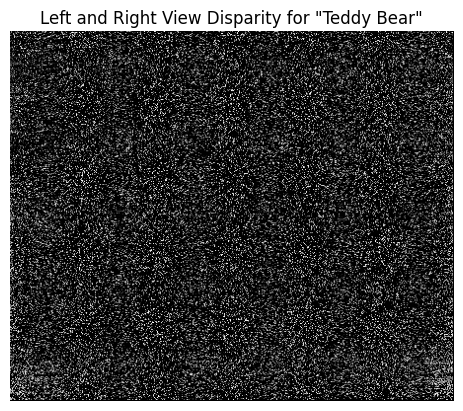

In [60]:
SimpleStereoDisparityMap.compute_and_visualize(
    left_img,
    right_img,
    SimilarityMeasure.SAD,
    rank_transform_filter_side_length=5,
    window_size=3,
    scene_name="Teddy Bear",
    do_logging=False,
    stride=1,
    padding_type="zero",
)